In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

from scipy.stats.stats import pearsonr
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


from time import time

# supress some warnings that mess up my slides
import warnings; warnings.simplefilter('ignore')

In [2]:
student_name = "Pyakorn Munegan (Mona)"
student_id = "46318461"

# COMP6200 Portfolio 2

# Data driven prediction models of energy use of appliances in alow-energy house

The goal of the second portfolio is to reproduce some work on predicting the energy usage of a house based on Internet of Things (IoT) measurements of temperature and humidity and weather observations.

__Introduction:__ the electricity consumption in domestic buildings is explained by two main factors: the type and number of electrical appliances and the use of the appliances by the occupants. Naturally, both factors are interrelated. The domestic appliances use by the occupants would leave traceable signals in the indoor environment near the vicinity of the appliance, for example: the temperature, humidity, vibrations, light and noise. The occupancy level of the building in different locations could also help to determine the use of the appliances. In this work, the prediction was carried out using different data sources and environmental parameters (indoor and outdoor conditions). Specifically, data from a nearby airport weather station, temperature and humidity in different rooms in the house from a wireless sensor network and one sub-metered electrical energy consumption (lights) have been used to predict the energy use by appliances.

This work explores several questions. Is the weather data obtained from a nearby weather station representative enough to improve the appliances energy consumption prediction? Can the temperature and humidity measurements from a wireless network help in the energy prediction? From all the data used in prediction models, which parameters are the most important in energy prediction?

In [3]:
test = pd.read_csv('data/testing.csv', index_col='date', parse_dates=True)
#testing.head() #4932 rows × 31 columnss

train = pd.read_csv('data/training.csv', index_col='date', parse_dates=True)
#training.head()#14803 rows × 31 columns

#combine testing and training to new dataframe 'data'
data = pd.concat([train, test] , axis=0)
data.head()
#data.shape #19735 rows× 31 columnss

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [4]:
data.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2', 'NSM', 'WeekStatus', 'Day_of_week'],
      dtype='object')

### Dataset and Exploratory Analysis:

The combined data set is split in training and test validation using CARET’S create data partition function. 75% of the data is used for the training of the models and the rest is used for testing.

### Appliances energy consumption measurement

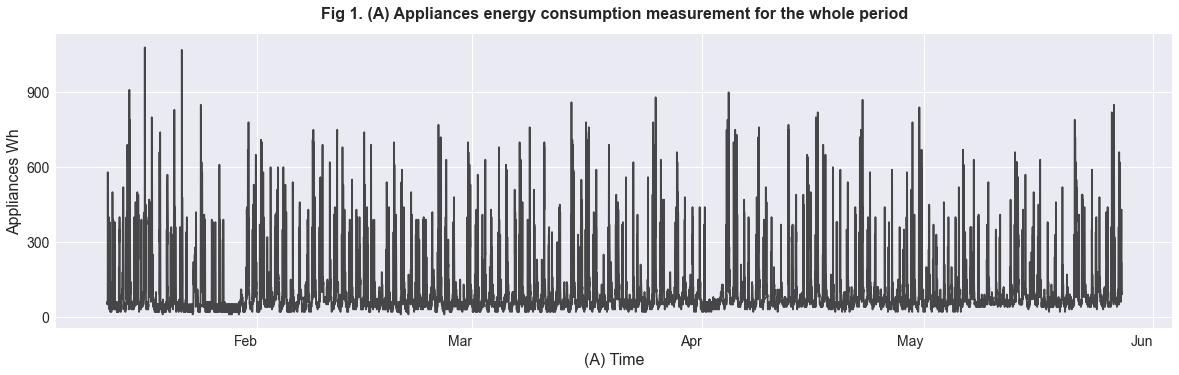

In [5]:
#set locator and date format %b - Jan, Feb, Mar...
locator = mdates.MonthLocator() 
fmt = mdates.DateFormatter('%b') 

g1 = data.Appliances.plot(figsize=(20,6), c='black', alpha = 0.7, grid=True, markersize=0.5)
plt.title('Fig 1. (A) Appliances energy consumption measurement for the whole period', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('(A) Time', fontsize = 16)
plt.ylabel('Appliances Wh', fontsize = 16)
plt.xticks(rotation=0, fontsize= 14) 
plt.yticks(np.arange(0, 1200, 300), fontsize= 14)
ax = plt.gca().xaxis
ax.set_major_locator(locator)
ax.set_major_formatter(fmt)

plt.show()

From the whole period, the average appliance energy consumption is approximately 400 Wh. The highest appliance energy consumption is in January which is over 1,000 Wh.

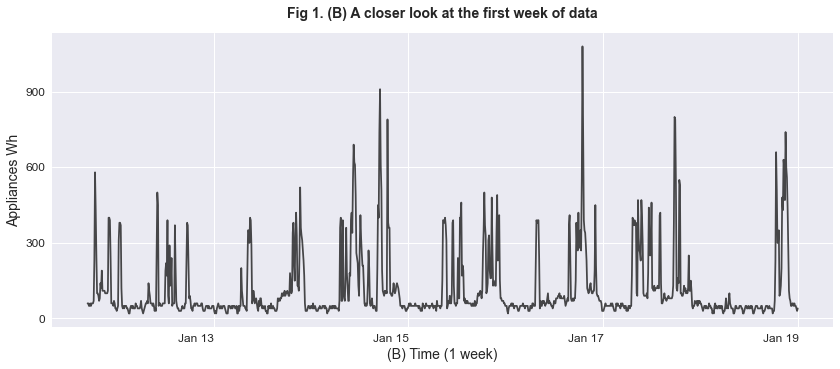

In [6]:
#set locator and date format
locator = mdates.DayLocator() 
fmt = mdates.DateFormatter('%b %d') 

start, end = '2016-1-11', '2016-1-18'
data.Appliances.loc[start:end].plot(figsize=(14,6), c='black', alpha = 0.7, grid=True)
plt.title('Fig 1. (B) A closer look at the first week of data', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('(B) Time (1 week)', fontsize = 14)
plt.ylabel('Appliances Wh', fontsize = 14)
plt.xticks(rotation=0, fontsize= 12) 
plt.yticks(np.arange(0, 1200, 300) , fontsize= 12)


ax = plt.gca().xaxis
ax.set_major_locator(locator)
ax.set_major_formatter(fmt)
ax.set_major_locator(mdates.DayLocator(bymonthday=(13, 15, 17, 19)))

plt.show()

Fig1.(B) includes all the energy consumed in the first week of data. The highest energy consumption is on January 17th

### Appliances energy consumption distribution

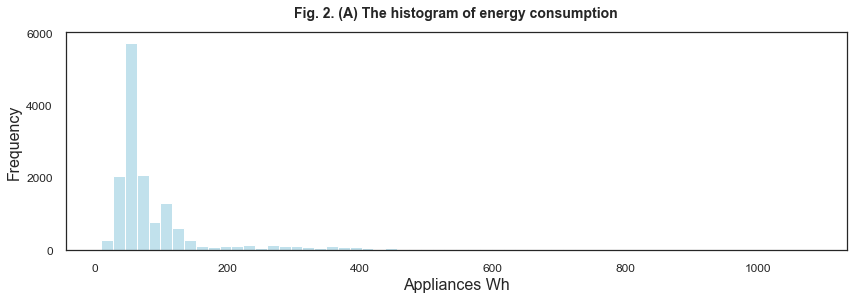

In [7]:
plt.figure(figsize=(14,4))
sns.set(style='white', font_scale=1)
sns.histplot(data=train, x='Appliances', bins=60, color='lightblue').set_facecolor('xkcd:white')
plt.title('Fig. 2. (A) The histogram of energy consumption', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Appliances Wh', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize= 12) 
plt.yticks(np.arange(0, 8000, 2000), fontsize= 12)

plt.show()

The histogram of energy consumption has a long right tail.

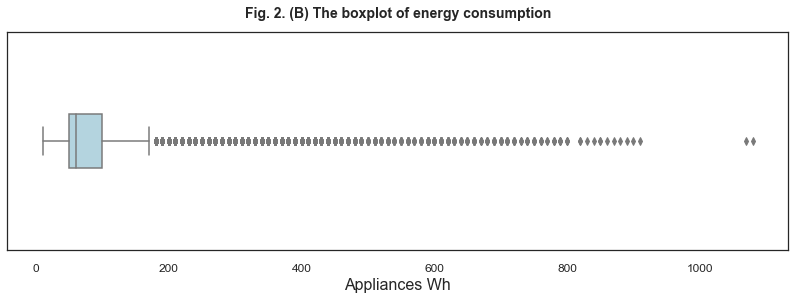

In [8]:
plt.figure(figsize=(14,4))
sns.set(style='white', font_scale=1)
sns.boxplot(x='Appliances', data=data, width=0.25, color='lightblue').set_facecolor('xkcd:white')
plt.title('Fig. 2. (B) The boxplot of energy consumption', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Appliances Wh', fontsize = 16)
plt.xticks(fontsize= 12) 
plt.yticks(fontsize= 12)
plt.show()

The median is defined by a thick black line within the blue rectangle with a value of 60 Wh in the boxplot. The lower whisker is 10 Wh, while the upper whisker is 170 Wh. It also reveals that data above the median is more diffuse, with many outliers (marked with the circles above the upper whisker)

### The correlation between the energy consumption of appliances and other variables

These Figures below show the bivariate scatterplots below the diagonal, histogram plots along the diagonal and the Pearson correlation above it, which is a measure of the linear dependence between two variables. A correlation of 1 is total positive correlation, −1 is total negative correlation and 0 representsno correlation. 
In red the linear regression fits are shown for each pair.

In [9]:
cols1 = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']
cols2 = ['Appliances', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6']
cols3 = ['Appliances', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
cols4 = ['Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'NSM', 'T6']

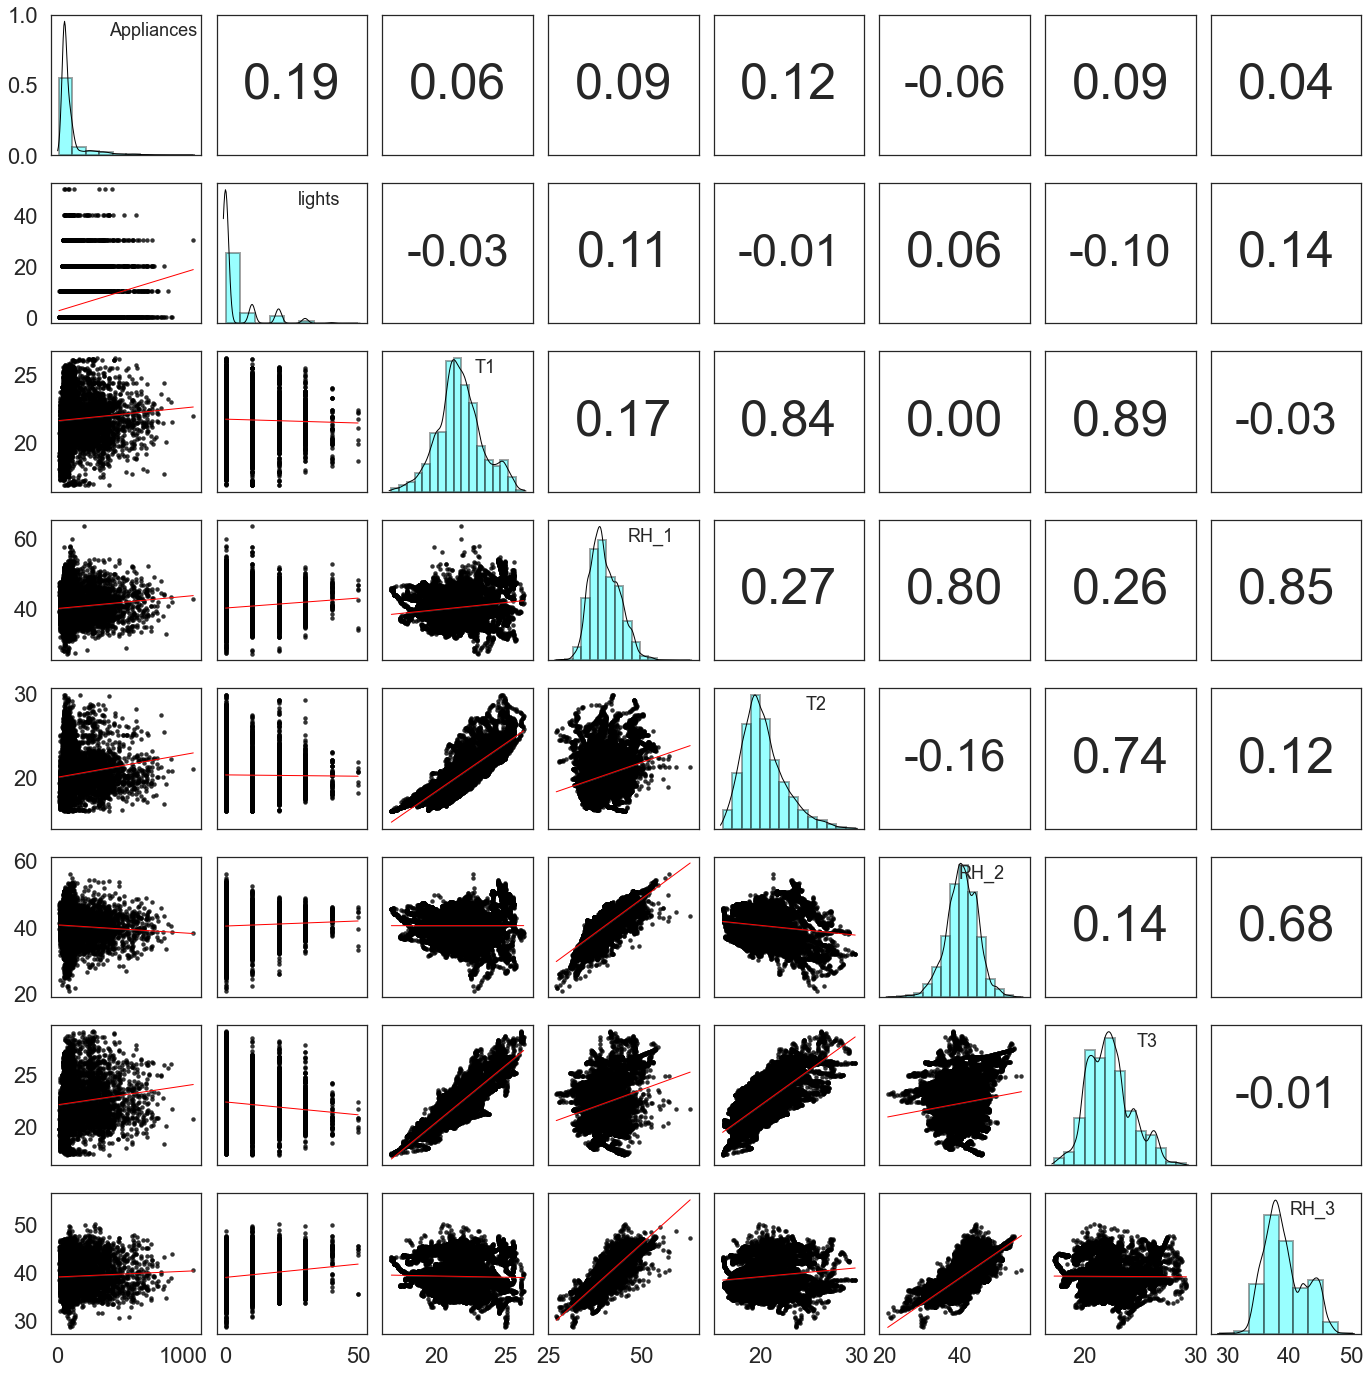

In [10]:
cols = iter(cols1)
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    #set corr font size
    if corr_r < 0.0:
        font_size = 45
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.68, 0.85), xycoords=ax.transAxes, fontsize = 18, ha="center")

#adjust no. of bins of each subplot on the diagonal
nbins = iter([10,9,17,16,14,15,13,9])
def myhist(*args, **kwargs):
    sns.distplot(*args, bins=next(nbins), **kwargs)

#PairGrid
sns.set(style='white', font_scale=2)
g = sns.PairGrid(train, vars=cols1, aspect=1.0, diag_sharey=False, despine=False, height=2.5).map_diag(diagfunc)


g.map_upper(corrdot)
g.map_diag(myhist,
          hist_kws = {'histtype': 'bar', 'edgecolor': 'k', 'lw': 2,  'facecolor':'aqua'}, 
          kde_kws = {'color': 'black', 'lw': 1, 'cut': 0.7}) 
g.map_lower(sns.regplot, ci=False,
            line_kws = {'color': 'red', 'lw': 1},
            scatter_kws = {'color': 'black', 's': 20})


g.fig.subplots_adjust(wspace=0.1, hspace=0.2)

#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

Fig. 3. (A) Pairs grid. Relationship between the energy consumption of appliances with lights, T1, RH1, T2, RH2, T3, RH3. T1 and RH1 correspond to the kitchen conditions; T2 and RH2 correspond to the living room conditions; T3 and RH3 correspond to the laundry room conditions.

The energy consumption of appliances and lights have a positive relationship (0.19). Appliances and T2 have the second-largest correlation. For the indoor temperatures and humidity, the correlations are high as expected, since the ventilation is driven by the HRV unit and minimizes air temperature differences between rooms. For example, a positive correlation is found with T1 and T3 (0.89) or RH1 and RH3 (0.85)




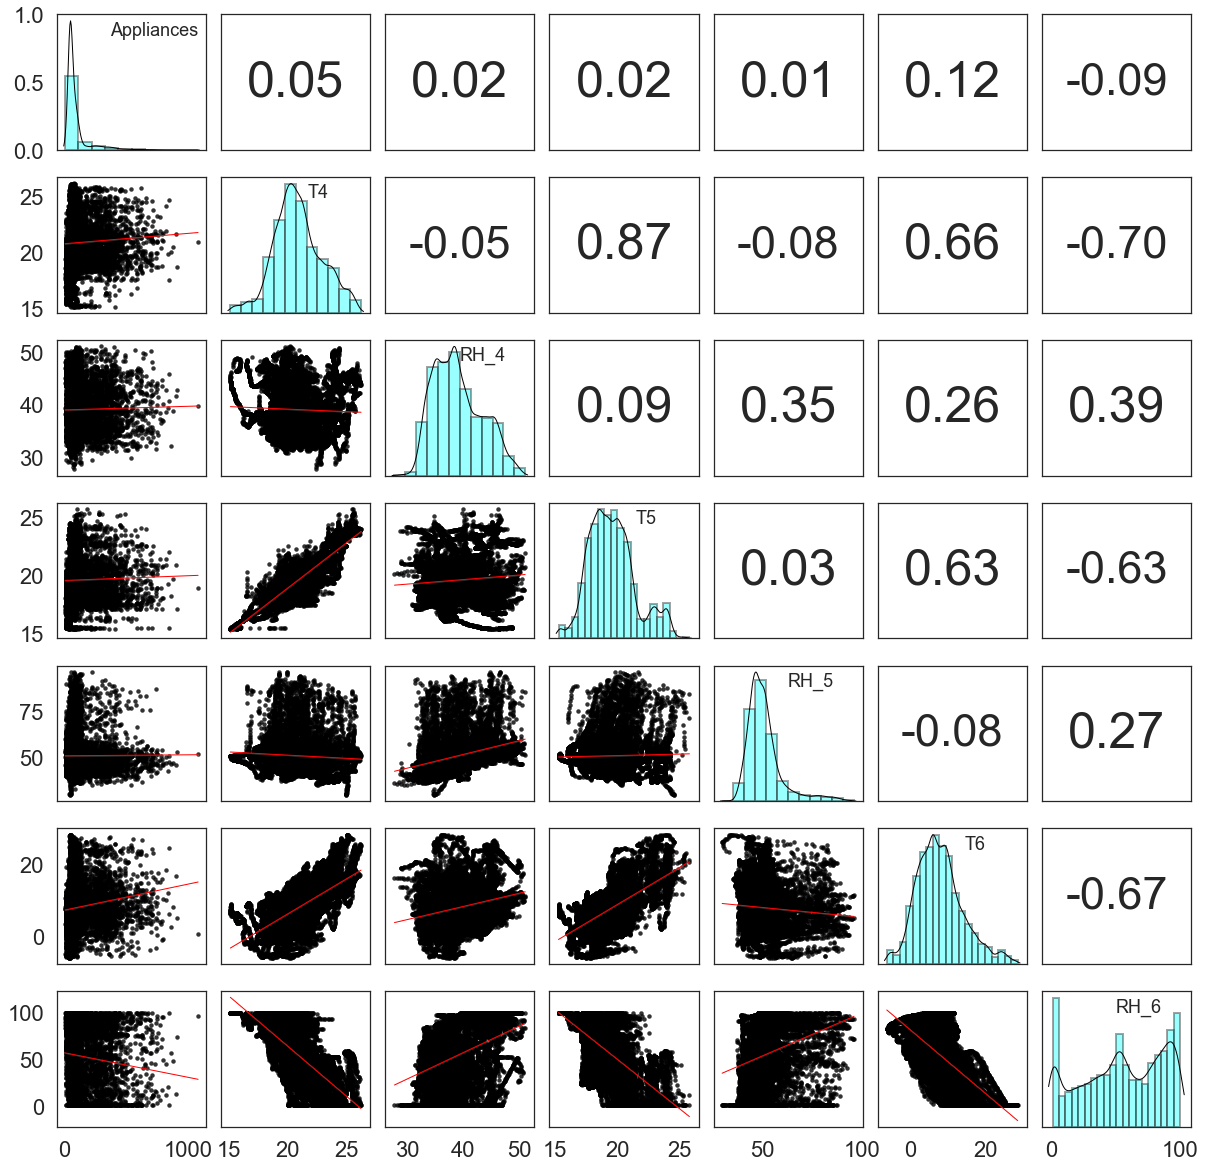

In [11]:
cols = iter(cols2)
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    #set corr font size
    if corr_r < 0.0:
        font_size = 45
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.65, 0.85), xycoords=ax.transAxes, fontsize = 18, ha="center")

#adjust no. of bins of each subplot on the diagonal
nbins = iter([10,12,12,20,12,20,20])
def myhist(*args, **kwargs):
    sns.distplot(*args, bins=next(nbins), **kwargs)

#PairGrid
sns.set(style='white', font_scale=2)
g = sns.PairGrid(train, vars=cols2, aspect=1.0, diag_sharey=False, despine=False, height=2.5).map_diag(diagfunc)

g.map_upper(corrdot)
g.map_diag(myhist,
          hist_kws = {'histtype': 'bar', 'edgecolor': 'k', 'lw': 2,  'facecolor':'aqua'}, 
          kde_kws = {'color': 'black', 'lw': 1, 'cut': 0.7}) 
g.map_lower(sns.regplot, ci=False,
            line_kws = {'color': 'red', 'lw': 1},
            scatter_kws = {'color': 'black', 's': 20})


g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.2)

#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

Fig. 3. (B) Pairs plot. Relationship between the energy consumption of appliances with T4, RH4, T5, RH5, T6, RH6. T4 and RH4 correspond to the office room conditions; T5 and RH5 correspond to the bathroom room conditions; T6 and RH6 correspond to the outside the building (north side) conditions.

The plot shows that the highest correlation with the appliances is between the outdoor temperature (0.12). A negative relationship exists between the appliances and outdoor humidity: RH6 (-0.09). The highest positive correlation between indoor  temperatures is found with office room:T4 and bathroom:T5 (0.87).

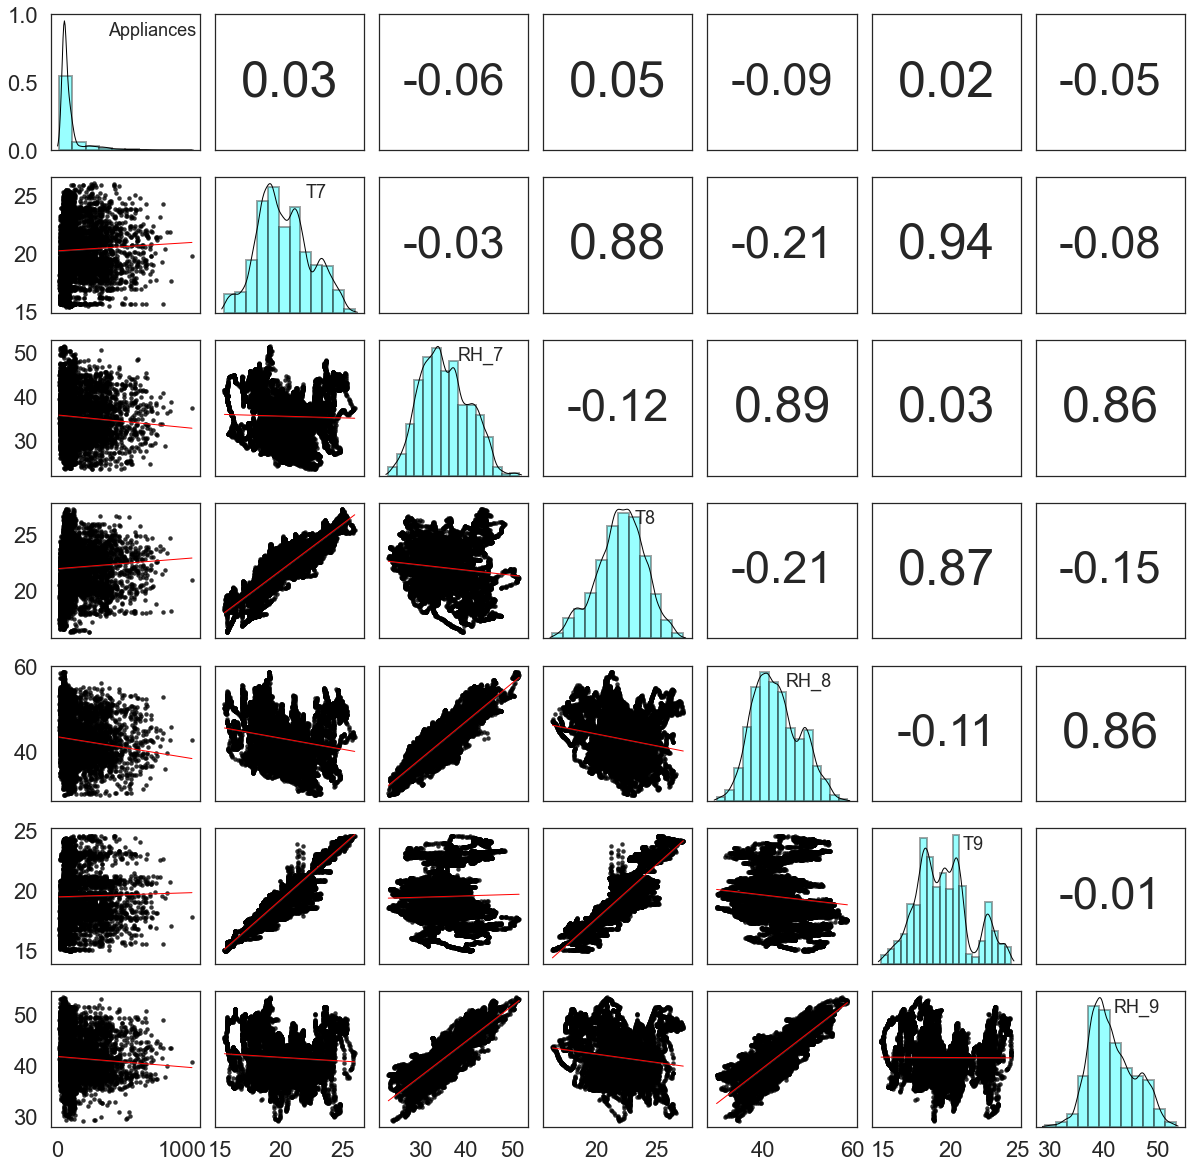

In [12]:
cols = iter(cols3)
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    #set corr font size
    if corr_r < 0.0:
        font_size = 45
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.68, 0.85), xycoords=ax.transAxes, fontsize = 18, ha="center")

#adjust no. of bins of each subplot on the diagonal
nbins = iter([10,12,15,12,15,20,12])
def myhist(*args, **kwargs):
    sns.distplot(*args, bins=next(nbins), **kwargs)

#PairGrid
sns.set(style='white', font_scale=2)
g = sns.PairGrid(train, vars=cols3, aspect=1.0, diag_sharey=False, despine=False, height=2.5).map_diag(diagfunc)

g.map_upper(corrdot)
g.map_diag(myhist,
          hist_kws = {'histtype': 'bar', 'edgecolor': 'k', 'lw': 2,  'facecolor':'aqua'}, 
          kde_kws = {'color': 'black', 'lw': 1, 'cut': 0.7}) 
g.map_lower(sns.regplot, ci=False,
            line_kws = {'color': 'red', 'lw': 1},
            scatter_kws = {'color': 'black', 's': 20})


g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.2)

#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

Fig. 3. (C) Pairs plot. Relationship between the energy consumption of appliances with T7, RH7, T8, RH8, T9, RH9. T7 and RH7 correspond to the ironing room conditions; T8 and RH8 correspond to the teenager room 2 conditions; T9 and RH9 correspond to the parent's room conditions.

The positive correlations between appliance consumption and T7, T8, and T9 are 0.03, 0.05, and 0.02 respectively. The highest positive correlation between indoor temperatures is found with the ironing room: T7 and the parent's room: T9 (0.94).

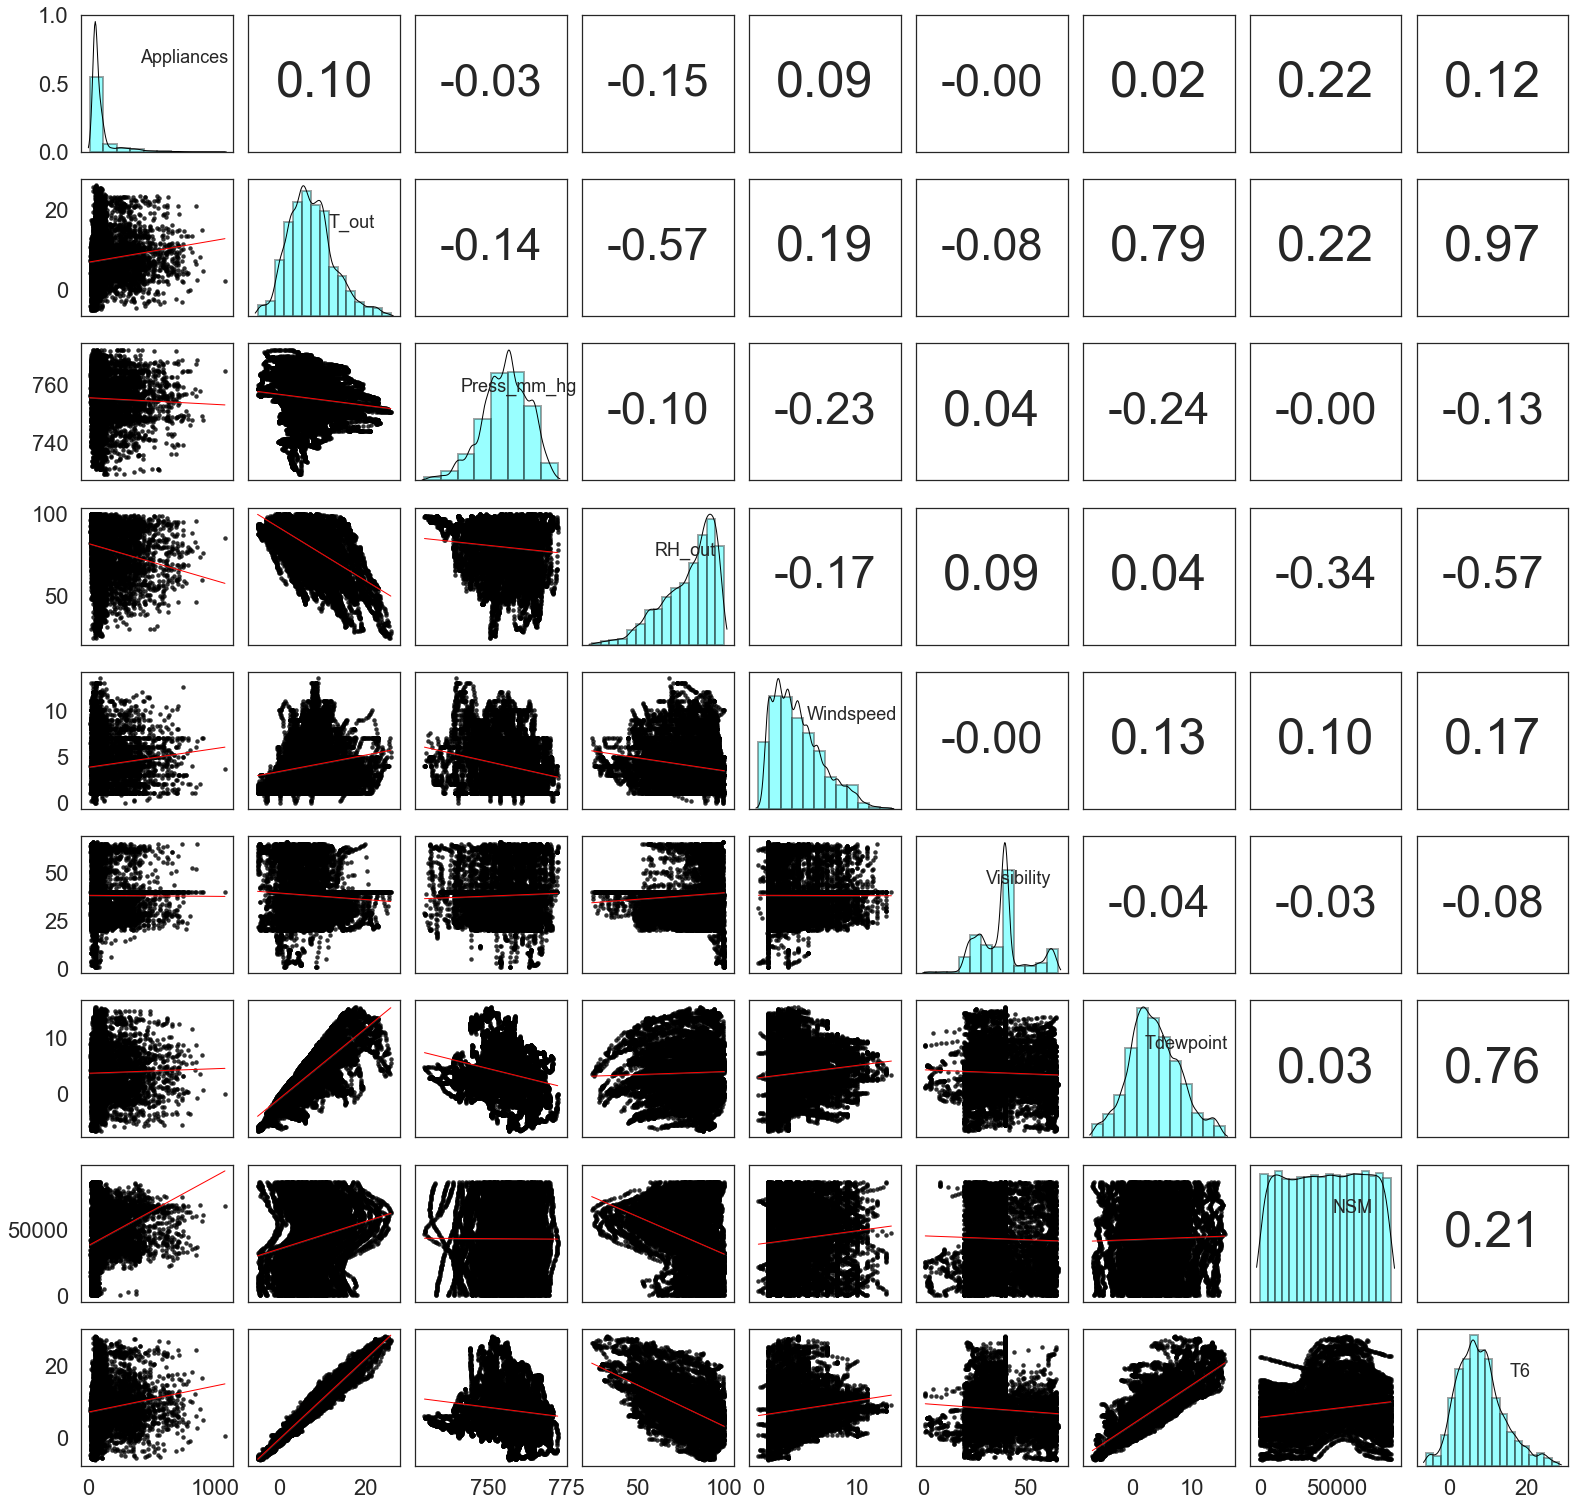

In [13]:
cols = iter(cols4)
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    #set corr font size
    if corr_r < 0.0:
        font_size = 45
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.68, 0.65), xycoords=ax.transAxes, fontsize = 18, ha="center")

#adjust no. of bins of each subplot on the diagonal
nbins = iter([10,15,8,15,12,12,12,18,18])
def myhist(*args, **kwargs):
    sns.distplot(*args, bins=next(nbins), **kwargs)

#PairGrid
sns.set(style='white', font_scale=2)
g = sns.PairGrid(train, vars=cols4, aspect=1.0, diag_sharey=False, despine=False, height=2.5).map_diag(diagfunc)

g.map_upper(corrdot)
g.map_diag(myhist,
          hist_kws = {'histtype': 'bar', 'edgecolor': 'k', 'lw': 2,  'facecolor':'aqua'}, 
          kde_kws = {'color': 'black', 'lw': 1, 'cut': 0.7}) 
g.map_lower(sns.regplot, ci=False,
            line_kws = {'color': 'red', 'lw': 1},
            scatter_kws = {'color': 'black', 's': 20})


g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.2)

#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

Fig. 3. (D) Pairs plot. Relationship between the energy consumption of appliances with T_out, Pressure_mm_gh, RH_out, Windspeed, Visibility, Tdewpoint, NMS.
T_out, Pressure_mm_gh, RH_out, Windspeed, Visibility and Tdewpoint correspond to the outside area (from Chièvres weather station); and NSM is the number of seconds from midnight.

This figure shows the highest correlation between the energy consumption of appliances and NSM with a value of 0.22. A positive correlation of 0.10 is seen between appliances’ consumption and outdoor temperature (T_out) that is the higher temperatures, the higher the energy use by the appliances.

Furthermore, there is a positive correlation between appliance consumption and wind speed (0.09), with higher wind speeds corresponding to higher appliance energy consumption. A negative correlation of −0.15 was found with the RHout, and of −0.03 with pressure. Another important and interesting correlation is between the pressure and the wind speed. This is a negative relationship (0.23). The linear pattern is that when the pressure is lower, the wind speed is higher.

__Heatmap__

In [14]:
#get Hour from strftime
data['Hour_of_day'] = data.index.strftime("%H") 
data['Hour_of_day'] = data['Hour_of_day'].astype(int) #convert from datetime object to int
#create Date from strftime
data['Date'] = data.index.strftime("%Y-%m-%d") 
#data.dtypes

#create new df 'Hourly_data' 
cols = ['Date', 'Hour_of_day', 'Day_of_week', 'Appliances']
Hourly_data = data[cols]
#Hourly_data #19735

#create column 'Days' to store the short name of Day_of_week
days = {'Monday':'Mon', 'Tuesday':'Tues', 'Wednesday':'Weds', 'Thursday':'Thurs', 'Friday':'Fri', 'Saturday':'Sat','Sunday':'Sun'}
Hourly_data['Days'] = Hourly_data['Day_of_week'].apply(lambda x: days[x])
#re-order Days column
Hourly_data['Days'] = pd.Categorical(Hourly_data['Days'], categories=['Sun', 'Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat']
                                     , ordered=True)

#drop Day_of_week column
drop_cols = ['Day_of_week'] #drop Appliances column
Hourly_data.drop(drop_cols, axis=1, inplace=True)
#Hourly_data

#Calculate the maximum of Appliances
max_value = Hourly_data.groupby(['Date','Hour_of_day'])['Appliances'].transform('sum').max() #max_value #3650
min_value = Hourly_data.groupby(['Date','Hour_of_day'])['Appliances'].transform('sum').min()
print('Max appliances: ' , max_value , 'and min appliances: ', min_value)

Max appliances:  3650 and min appliances:  170


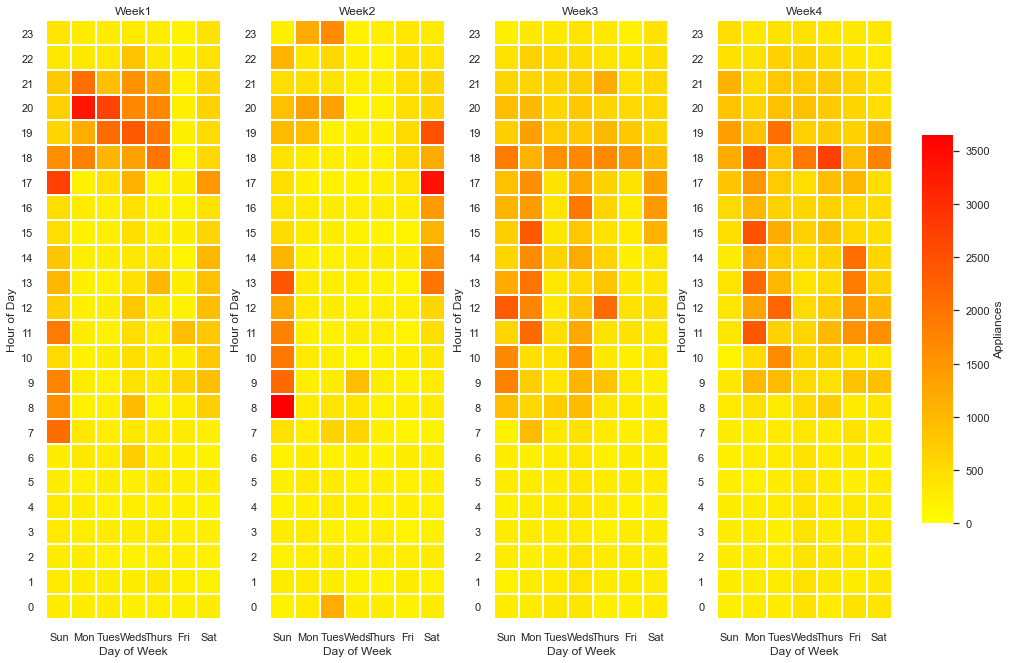

In [15]:
Week1 = Hourly_data.loc['2016-01-17':'2016-01-23']
Week2 = Hourly_data.loc['2016-01-24':'2016-01-30']
Week3 = Hourly_data.loc['2016-01-31':'2016-02-06']
Week4 = Hourly_data.loc['2016-02-07':'2016-02-13']

#reshape the data in long form to wide form using Pandas’s pivot_table() function.
heatmap_data1 = pd.pivot_table(Week1, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data2 = pd.pivot_table(Week2, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data3 = pd.pivot_table(Week3, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data4 = pd.pivot_table(Week4, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')

#create list 'Hours' to store the reverse sorted of Hour_of_day
Hours=Hourly_data.Hour_of_day.unique().tolist()
Hours=sorted(Hours, reverse=True)

heatmap_data1=heatmap_data1.loc[Hours]
heatmap_data2=heatmap_data2.loc[Hours]
heatmap_data3=heatmap_data3.loc[Hours]
heatmap_data4=heatmap_data4.loc[Hours]

sns.set(style='white', font_scale=1)
fig, ax = plt.subplots(1, 4, figsize = (14, 18))
cbar_ax = fig.add_axes([.91, .35, .03, .3])
fig.tight_layout(rect=[0, 0, .9, 1])


g1 = sns.heatmap(heatmap_data1, ax=ax[0], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='Hour of Day',
                                                                                    title = 'Week1')

g2 = sns.heatmap(heatmap_data2, ax=ax[1], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='Hour of Day',
                                                                                    title = 'Week2')

g3 = sns.heatmap(heatmap_data3, ax=ax[2], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='Hour of Day',
                                                                                   title = 'Week3')

g4 = sns.heatmap(heatmap_data4, ax=ax[3], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value,  
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='Hour of Day',
                                                                                  title = 'Week4')

#rotate xtick labels
def rotate_xticks(ax: matplotlib.axes, degrees : float = 360):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=degrees)
rotate_xticks(ax=ax[0])
rotate_xticks(ax=ax[1])
rotate_xticks(ax=ax[2])
rotate_xticks(ax=ax[3])

#rotate ytick labels
def rotate_yticks(ax: matplotlib.axes, degrees : float = 360):
    ax.set_yticklabels(ax.get_yticklabels(), rotation=degrees)
rotate_yticks(ax=ax[0])
rotate_yticks(ax=ax[1])
rotate_yticks(ax=ax[2])
rotate_yticks(ax=ax[3])

plt.show()

An hourly heat map was generated for four consecutive weeks of data to identify any time trends. As can be clearly seen, there is a strong time component in the energy consumption pattern. The energy consumption starts to rise around 6 in the morning. Then around noon, there are energy load surges. The energy demand also increases around 6 pm. There is no clear pattern regarding the day of the week.

### Performance of Regression Models:


__Training and Testing data set__

| Data set  | Number of observations |
| --- | --- |
| Traning | 14,803 and 32 variables|
| Testing |  4,932 and 32 variables|


In [16]:
#Preparing training and testing data
cols = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 
        'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 
        'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'Visibility', 
        'RH_out', 'Windspeed', 'Tdewpoint', 'NSM', 'Day_of_week']

X_train = train[cols]
X_train = pd.get_dummies(X_train, columns = ['Day_of_week'])
y_train = train['Appliances']

X_test = test[cols]
X_test = pd.get_dummies(X_test, columns = ['Day_of_week'])
y_test = test['Appliances']

In [17]:
#Train model with train data
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [ 1.85514349e+00 -5.91623712e+00  1.45115663e+01 -1.78907829e+01
 -1.38360616e+01  2.63682598e+01  6.28860382e+00  9.24488963e-01
 -4.84922719e-01 -1.46004124e+00  6.80289266e-02  7.07362501e+00
  2.90309897e-01  1.41094452e+00 -1.62558312e+00  8.34559362e+00
 -4.13546815e+00 -1.30500097e+01 -3.80092173e-01 -9.70071004e+00
  1.80488089e-01  1.87709260e-01 -7.82451548e-01  1.78827983e+00
  3.63247626e+00  2.88265474e-04  9.29698271e+00  3.14175619e+00
  1.50828892e+01 -1.21863889e+00 -7.78019450e+00 -1.09996391e+01
 -7.52315560e+00] + -72.70436946022856


In [18]:
#reporting RMSE, R2-score, MAE and MAPE% on train set
y_train_pred = reg.predict(X_train)

def mean_absolute_percentage_error(y_train, y_train_pred):
    y_train, y_train_pred = np.array(y_train), np.array(y_train_pred)
    return np.mean(np.abs((y_train-y_train_pred)/y_train))*100

rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
mape = mean_absolute_percentage_error(y_train, y_train_pred)

print('RMSE on train set: ', rmse.round(2))
print('R2-score on train set: ', r2.round(2))
print('MAE on train set: ', mae.round(2))
print('MAPE% on train set: ', mape.round(2))

RMSE on train set:  93.21
R2-score on train set:  0.18
MAE on train set:  53.13
MAPE% on train set:  61.32


In [19]:
#reporting RMSE, R2-score, MAE and MAPE% on test set
y_test_pred = reg.predict(X_test)

def mean_absolute_percentage_error(y_test, y_test_pred):
    y_test, y_test_pred = np.array(y_test), np.array(y_test_pred)
    return (np.mean(np.abs((y_test-y_test_pred)/y_test))*100)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)

print('RMSE on test set: ', rmse.round(2))
print('R2-score on test set: ', r2.round(2))
print('MAE on test set: ', mae.round(2))
print('MAPE% on test set: ', mape.round(2))

RMSE on test set:  93.18
R2-score on test set:  0.16
MAE on test set:  51.97
MAPE% on test set:  59.94


In [22]:
residuals = y_test - y_test_pred

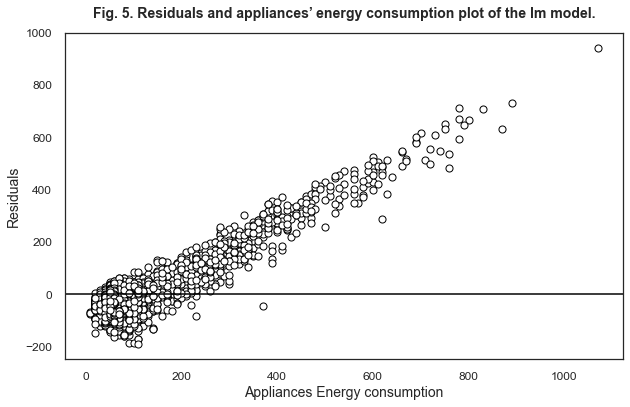

In [23]:
#Plot residuals and Appliances Energy consumption
sns.set(style='white', font_scale=1)
fig, axs = plt.subplots(figsize = (10, 6))
sns.scatterplot(y_test, residuals,  edgecolor='black', color = 'white', s=50, linewidth=1)
axs.tick_params(axis='both', labelsize=14)
axs.axhline(y=0, color='black') # create line y=0 
plt.xlabel(xlabel='Appliances Energy consumption', fontsize = 14)
plt.ylabel(ylabel='Residuals', fontsize = 14)
plt.title('Fig. 5. Residuals and appliances’ energy consumption plot of the lm model.', fontsize = 14, fontweight='bold', pad=15)
plt.yticks(np.arange(-200, 1200, 200), fontsize= 12)
plt.xticks(np.arange(0, 1200, 200), fontsize= 12)

plt.show()

A residual plot for the linear regression model is shown in Figure 5. The difference between the actual and expected values was used to calculate the residuals. It is obvious that the relationship between the variables and the energy consumption of appliances is not well represented by the linear model since the residuals are not normally distributed around the horizontal axis. In order to compare the performance of each of the regression models, different performance evaluation indices are used here: 

* The root mean squared error (RMSE)  

$$RMSE = \sqrt{\frac {\sum_{n}^{i=1}(Y_{i} - \hat{Y}_{i})^{2}}{n}}$$

* The coefficient of determina-tion or R-squared/R2

$$ R^{2} = 1 - \frac {\sum_{n}^{i=1}(Y_{i} - \hat{Y}_{i})^{2}}{\sum_{n}^{i=1}(Y_{i} - {\overline{Y}}_{i})^{2}} $$

* The mean absolute error (MAE)

$$MAE = \frac {\sum_{n}^{i=1}(|Y_{i} - \hat{Y}_{i}|)}{n}$$

* The meanabsolute percentage error (MAPE)

$$MAPE = \frac {1}{n} \sum_{i=1}^{n} \frac {|Y_{i} - \hat{Y}_{i}|}{Y_{i}}$$



### Linear Regression model performance
* Training

| RMSE | $R^2$ | MAE | MAPE% |
| ---: | ---: | ---: | ---: |
| 93.21 | 0.18 | 53.13 | 61.32 |

* Testsing

| RMSE | $R^2$ | MAE | MAPE% |
| ---: | ---: | ---: | ---: |
| 93.18 | 0.16 | 51.97 | 59.94 |



### Feature Importance

In [24]:
cols = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 
        'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 
        'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'Visibility', 
        'RH_out', 'Windspeed', 'Tdewpoint', 'NSM', 'WeekStatus', 'Day_of_week']

X = data[cols]
X = pd.get_dummies(X, columns = ['WeekStatus', 'Day_of_week'])
y = data['Appliances']

In [25]:
#Recursive feature elimination with cross-validation
model= linear_model.LinearRegression()
start = time()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(n_splits=5), scoring='neg_root_mean_squared_error', 
              min_features_to_select = 1)
rfecv.fit(X, y)
y_pred = rfecv.predict(X)

print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Time: ', time() - start)

Optimal number of features: 22
Time:  1.7486019134521484


__Plot number of features VS. cross-validation scores__

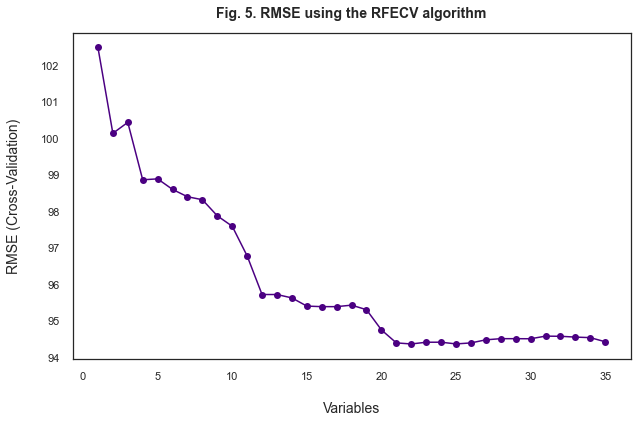

In [26]:
plt.figure(figsize=(10, 6))
sns.set(style='white', font_scale=1)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), -rfecv.grid_scores_, color='indigo', marker='o', markersize = 7)
plt.title('Fig. 5. RMSE using the RFECV algorithm', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Variables', fontsize=14, labelpad=20)
plt.ylabel('RMSE (Cross-Validation)', fontsize=14, labelpad=20)
plt.show()

Fig. 5 shows the result of the RFE algorithm. The optimal number of predictors is 22.

The model performance increases dramatically when predictor variables are increased from 1 to about 22 variables, as shown by the decrease in the MSE as the number of variables increases. Increasing the number of variables beyond 22 has little impact on the model performance.

### Conlusion

This portfolio aims to reproduce some graphs and output on the research paper "Data driven prediction models of energy use of appliances in alow-energy house. Firstly, we have explored the appliances of energy consumption by plotting time-series line charts to observe the trend over the period and using histograms and boxplot to check the distribution of the energy consumption. Then, performing pairGrids to discover the relation among various variables. After that, the hourly heat map was generated for four consecutive weeks of data to identify any time patterns.

Linear Regression model was performed. The residuals and Appliances Energy Consumption plot show that the linear model does not adequately represent the relationship between the variables and appliance energy consumption. In order to compare the performance of each of the regression models, different performance evaluation indices are used; RMSE, $R^{2}$, MAE and MAPE.

Finally, Recursive Feature Elimination with Cross-Validation was used to find the optimal number of predictors. The result is 22 variables different from the research which is 34 variables because, in the research, they performed by Random Forest (RF) model.